In [34]:
import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
import matplotlib
import os 

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import plot_tree, export_text
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (1 , 6)
matplotlib.rcParams['figure.facecolor'] = '#000000'

In [3]:
od.download('https://www.kaggle.com/jsphyg/weather-dataset-rattle-package')
os.listdir('./weather-dataset-rattle-package')
train_csv = './weather-dataset-rattle-package' + '/weatherAUS.csv'

Skipping, found downloaded files in "./weather-dataset-rattle-package" (use force=True to force download)


In [4]:
raw_df = pd.read_csv(train_csv)

In [5]:
raw_df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)

In [6]:
year = pd.to_datetime(raw_df.Date).dt.year
train_df, val_df, test_df = raw_df[year < 2015], raw_df[year == 2015], raw_df[year > 2015]

In [7]:
inputs_cols = list(train_df.columns[1:-1])
target_col = train_df.columns[-1]

train_inputs = train_df[inputs_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs = val_df[inputs_cols].copy()
val_targets = val_df[target_col].copy()

test_inputs = test_df[inputs_cols].copy()
test_targets = test_df[target_col].copy()

In [8]:
numeric_cols = train_inputs.select_dtypes(include= np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

In [9]:
imputer = SimpleImputer(strategy='mean').fit(raw_df[numeric_cols])

train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

In [10]:
scaler = MinMaxScaler().fit(raw_df[numeric_cols])

train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [17]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(train_inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [29]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [19]:
model = DecisionTreeClassifier(random_state=42)

In [20]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(random_state=42)

In [23]:
train_preds = model.predict(X_train)
pd.Series(train_preds).value_counts()

No     76192
Yes    21796
Name: count, dtype: int64

In [26]:
accuracy_score(train_preds, train_targets)

0.9999795893374699

In [31]:
train_prods = model.predict_proba(X_train)

In [32]:
model.score(X_val, val_targets)

0.794955819533033

In [33]:
val_targets.value_counts()/len(val_targets)

RainTomorrow
No     0.790626
Yes    0.209374
Name: count, dtype: float64

In [ ]:
plt.figure(figsize=(80, 40))
plot_tree(model, feature_names=X_train.columns, max_depth=2, filled=True)

In [39]:
model.tree_.max_depth

49

In [43]:
tree_text = export_text(model, feature_names=list(X_train.columns), max_depth=10)

In [44]:
model.feature_importances_

array([3.72126133e-02, 3.00581504e-02, 4.39596858e-02, 2.19935067e-02,
       4.81376428e-02, 5.93385653e-02, 2.53566569e-02, 3.01869912e-02,
       3.86339202e-02, 2.79708704e-01, 3.76083360e-02, 6.19613754e-02,
       1.43860659e-02, 1.65373175e-02, 3.58531574e-02, 3.03627947e-02,
       1.77427586e-03, 1.86966924e-03, 1.04614794e-03, 7.25486292e-04,
       1.35035854e-03, 8.93838044e-04, 1.27923203e-03, 1.87481626e-03,
       1.02981225e-03, 1.47685862e-03, 9.03942333e-04, 2.37248341e-03,
       1.52532800e-03, 4.87938277e-04, 8.12189022e-04, 1.54423566e-03,
       6.16690435e-05, 1.33274069e-03, 9.46368291e-04, 1.49523115e-03,
       7.34711882e-04, 1.13675372e-03, 1.22578775e-03, 1.74951767e-03,
       6.34676972e-04, 7.00342244e-04, 1.53411729e-03, 1.64222118e-03,
       1.34621747e-03, 7.71509160e-04, 7.49352103e-04, 1.44508260e-03,
       1.36505589e-03, 2.05880521e-03, 1.04036900e-03, 1.97000298e-03,
       1.39802439e-03, 2.04977586e-03, 1.13266465e-03, 4.32973396e-04,
      

In [46]:
importance_df = pd.DataFrame({
    'features' : X_train.columns,
    'importance' :model.feature_importances_
}).sort_values('importance', ascending=False)

In [47]:
importance_df.head(10)

,features,importance
9,Humidity3pm,0.279709
11,Pressure3pm,0.061961
5,WindGustSpeed,0.059339
4,Sunshine,0.048138
2,Rainfall,0.043960
8,Humidity9am,0.038634
10,Pressure9am,0.037608
0,MinTemp,0.037213
14,Temp9am,0.035853
15,Temp3pm,0.030363


In [49]:
?DecisionTreeClassifier

Init signature:
DecisionTreeClassifier(
    *,
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
    ccp_alpha=0.0,
    monotonic_cst=None,
)
Docstring:     
A decision tree classifier.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"gini", "entropy", "log_loss"}, default="gini"
    The function to measure the quality of a split. Supported criteria are
    "gini" for the Gini impurity and "log_loss" and "entropy" both for the
    Shannon information gain, see :ref:`tree_mathematical_formulation`.

splitter : {"best", "random"}, default="best"
    The strategy used to choose the split at each node. Supported
    strategies are "best" to choose the best split and "random" to choose
    the best random split.

max_depth : int, default=None

In [113]:
model = DecisionTreeClassifier(max_depth=8, random_state=42)
model.fit(X_train, train_targets)

DecisionTreeClassifier(max_depth=8, random_state=42)

In [114]:
model.score(X_train, train_targets)

0.8551863493488998

In [115]:
model.score(X_val, val_targets)

0.8459827959506115

In [116]:
model.classes_

array(['No', 'Yes'], dtype=object)

In [ ]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, max_depth=3, filled=True)

In [ ]:
print(export_text(model, feature_names=list(X_train.columns)))

In [123]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(X_train, train_targets)
    train_error = 1 - model.score(X_train, train_targets)
    val_error = 1 - model.score(X_val, val_targets)
    return {'Max Depth': md, 'Training Error': train_error, 'Validation Error' : val_error}

In [126]:
errors_df = pd.DataFrame([max_depth_error(md) for md in range (1,21)])

In [127]:
errors_df

,Max Depth,Training Error,Validation Error
0,1,0.181941,0.176488
1,2,0.176930,0.170695
2,3,0.168408,0.165194
3,4,0.162153,0.161624
4,5,0.157244,0.158113
5,6,0.153131,0.155890
6,7,0.149059,0.154661
7,8,0.144814,0.154017
8,9,0.139425,0.154719
9,10,0.131802,0.154953


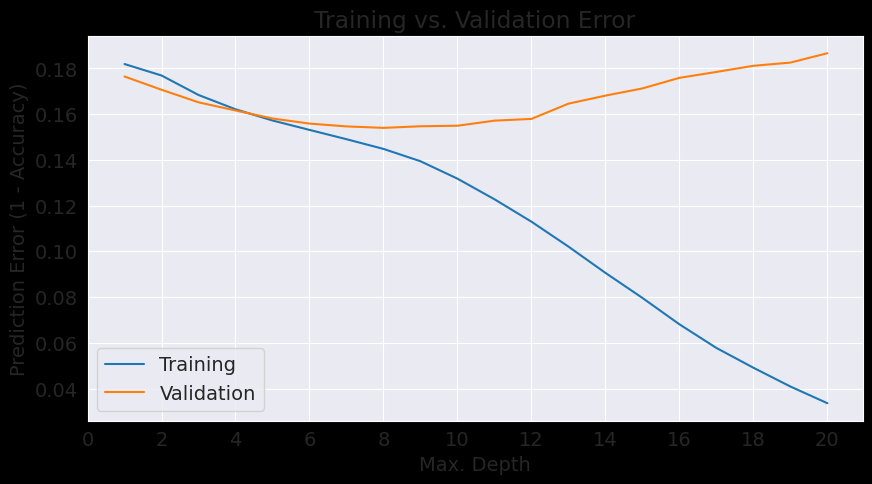

In [135]:
plt.figure(figsize=(10,5))
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0, 21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

In [144]:
model =  DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)
model.fit(X_train, train_targets)
model.score(X_train, train_targets)

0.852696248520227

In [145]:
model.score(X_val, val_targets)

0.8471531394464276

In [146]:
model.tree_.max_depth

11

In [138]:
model_text= export_text(model, feature_names=list(X_train.columns))
print(model_text[:3000])

|--- Humidity3pm <= 0.72
|   |--- Humidity3pm <= 0.51
|   |   |--- Sunshine <= 0.53
|   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |--- Pressure3pm <= 0.44
|   |   |   |   |   |--- Humidity3pm <= 0.24
|   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- Humidity3pm >  0.24
|   |   |   |   |   |   |--- Sunshine <= 0.37
|   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |--- Sunshine >  0.37
|   |   |   |   |   |   |   |--- class: No
|   |   |   |   |--- Pressure3pm >  0.44
|   |   |   |   |   |--- Humidity3pm <= 0.28
|   |   |   |   |   |   |--- class: No
|   |   |   |   |   |--- Humidity3pm >  0.28
|   |   |   |   |   |   |--- Cloud3pm <= 0.39
|   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |--- Cloud3pm >  0.39
|   |   |   |   |   |   |   |--- Location_Hobart <= 0.50
|   |   |   |   |   |   |   |   |--- WindGustSpeed <= 0.23
|   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |--- WindGustSpeed >  0.23